## Focus
## Duke Kunshan University Fall 2017
### David Brady
Monday 12 March 2018

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
from time import gmtime, strftime, sleep
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/home/dbrady/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


Let's start by grabbing an image from 10.0.1.6

here we use https://docs.python.org/2/library/re.htm to search a regular expression to find the image file name.
Here is a tutorial on regular expressions
http://www.tutorialspoint.com/python/python_reg_expressions.htm 


In the following code our goal is to grab an image from the camera and display it in the viewer

'Mon, 12 Mar 2018 05:59:48'

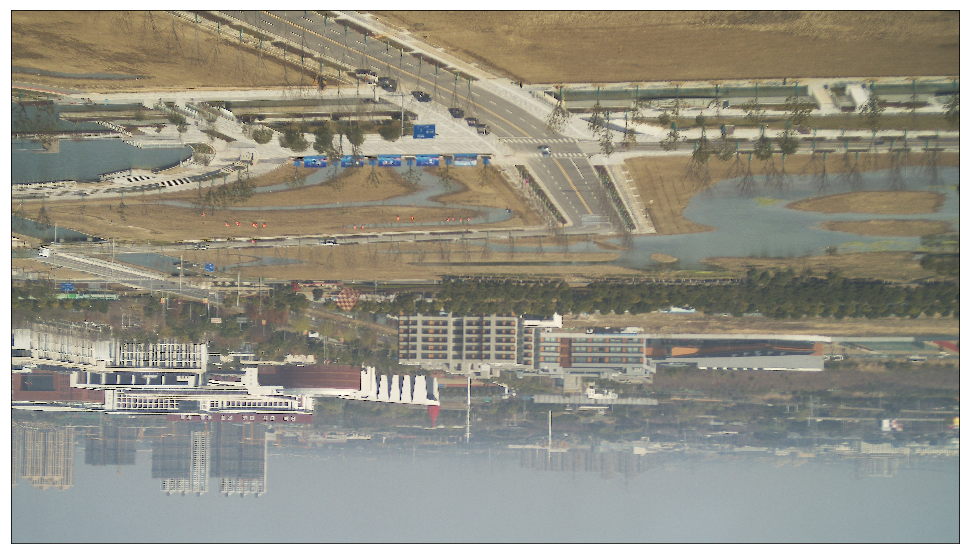

In [2]:
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
subprocess.run('rm dbGrab*', \
               stdout=subprocess.PIPE, shell=True)
subprocess.run('rsh ubuntu@10.0.1.6 "rm dbGrab*"', \
               stdout=subprocess.PIPE, shell=True)
# ok, now let's grab an image on the tegra
subprocess.run('rsh ubuntu@10.0.1.6 "nvgstcapture-1.0 -m 1 --sensor-id 1 -A --capture-auto 1 \
                --file-name dbGrab --image-res 8"', stdout=subprocess.PIPE, shell=True)
subprocess.run('rcp ubuntu@10.0.1.6:dbGrab* .', \
               stdout=subprocess.PIPE, shell=True)
#ok, now let's find the file name of the image we just grabbed and transfered 
pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
rePop=pop.stdout
rePop=rePop.decode("utf-8")
fileName = re.search(r'dbGrab(.*).jpg', rePop)
fileName=fileName.group()
pop=imio.imread(fileName)
pop=skimage.transform.rotate(pop,180)
fig=imio.imshow(pop)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
strftime("%a, %d %b %Y %H:%M:%S", gmtime())

we can also make the process of grabbing a frame from the camera into a function

In [53]:
def grabImage(sid=1, imres=8):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rsh ubuntu@10.0.1.6 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD='rsh ubuntu@10.0.1.6 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run('rcp ubuntu@10.0.1.6:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    pop=skimage.transform.rotate(pop,180)
    return pop

In [54]:
pip=grabImage(sid=1)

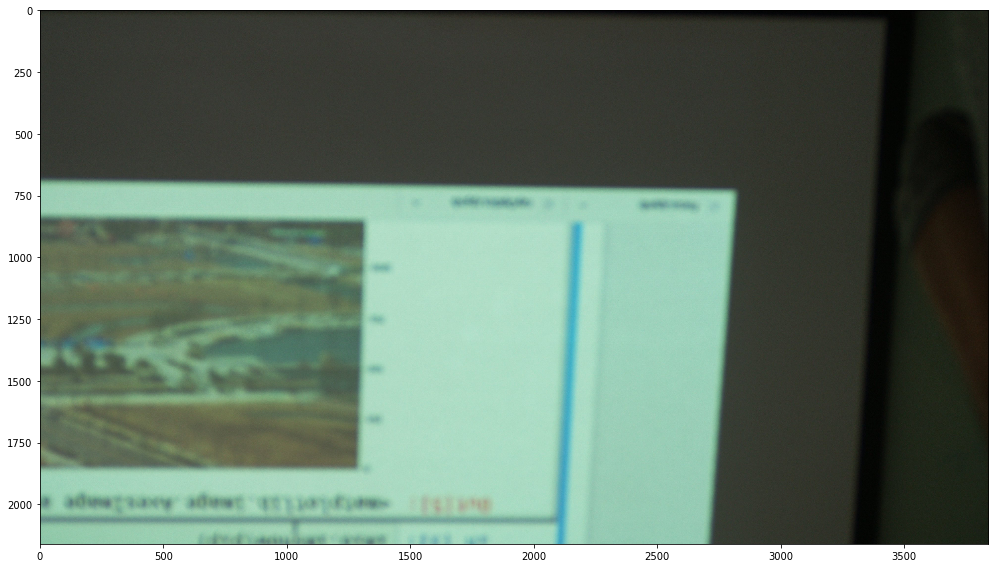

In [55]:
imio.imshow(pip)

In [59]:
pip=grabImage(sid=0, imres=3)

In [57]:
pip.shape

(720, 1280, 3)

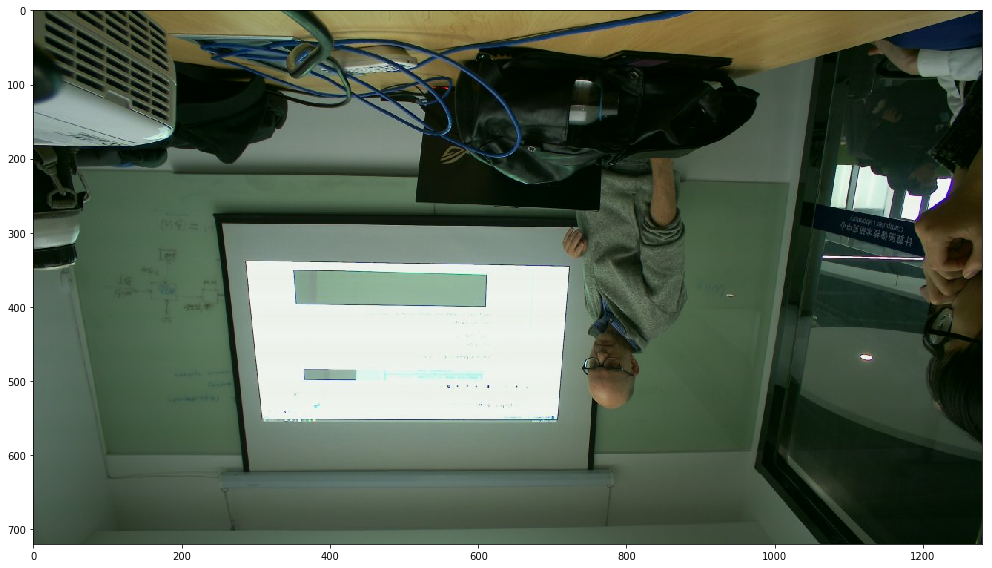

In [60]:
imio.imshow(pip)

The python program ~/bin/moveFocusMotor.py moves the focus of the camera

here is what you see if you try to run it on the tegra with no arguments

ubuntu@tegra-ubuntu:~/bin$ ./moveFocusMotor.py -h
address is 0
busnumber is <smbus.SMBus object at 0x7f982430b0>
im initializing here
['-h']
did not get enough arguments, must specify motor ID of 1 or 2 and number of steps
For example python moveFocusMotor.py 2 -50
ubuntu@tegra-ubuntu:~/bin$ 

let's make a function to move it a bit and then display the resulting image


In [61]:
def moveFocus(sid=1, step=1):
    cmD='rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py '+str(sid)+' '+str(step)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    print(cmD)
    return pop.stdout
def resetFocus(sid=1):
    cmD='rsh ubuntu@10.0.1.6 "python2 ~/bin/resetFocusMotor.py '+str(sid)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

In [15]:
a=moveFocus(sid=2,step=50)

rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 2 50"


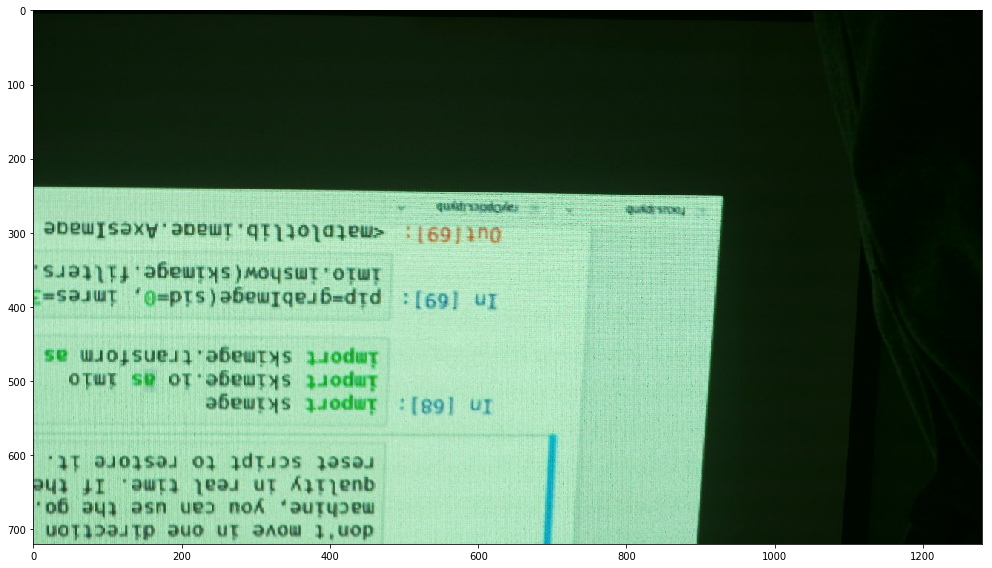

In [70]:

imio.imshow(grabImage(sid=1, imres=3))

Now let's work on finding the point of best focus. When moving the focus motors, be careful not to move too far. Move in steps of 100, don't move in one direction more than 1000 steps. If you have a linux machine, you can use the go.sh and recieve.sh scripts to monitor image quality in real time. If the focus motor becomes stuck you can use the reset script to restore it. 

In [68]:
import skimage
import skimage.io as imio
import skimage.transform as trans

rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 2 150"
77107.7960784


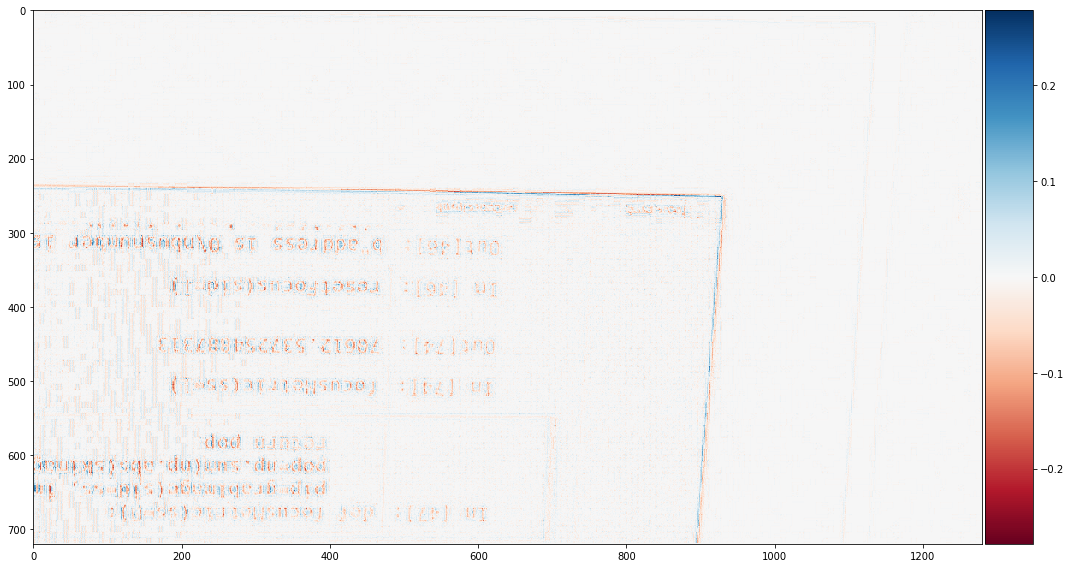

In [79]:
a=moveFocus(sid=2,step=150)
pip=grabImage(sid=1, imres=3)
print(focusMetric(ss=1))
imio.imshow(skimage.filters.laplace(pip[:,:,1]))

In [47]:
def focusMetric(ss=0):
    pip=grabImage(sid=ss, imres=8)
    pop=np.sum(np.abs(skimage.filters.laplace(pip[:,:,1])))
    return pop

In [74]:
focusMetric(ss=1)

70612.537254887313

In [80]:
resetFocus(sid=1)

b"address is 0\nbusnumber is <smbus.SMBus object at 0x7fa84740b0>\nim initializing here\n['1']\nnow my address is 96\nnow my bus is 30\naddress is 96\nbusnumber is <smbus.SMBus object at 0x7fa8474170>\nim initializing here\ntrying to reset here\ntrying to build command here\n01010a0400\ndata part of command is [1, 1, 10, 4, 0]\nWidth        = 16\nPoly         = 0x1021\nReflectIn    = False\nXorIn        = 0x0000\nReflectOut   = False\nXorOut       = 0x0000\nAlgorithm    = UNDEFINED\n\ncrc is 216\nI think the full cmd should be [126, 215, 224, 1, 1, 10, 4, 0, 126]\nI2C: Writing list to register 0x60:\n[126, 215, 224, 1, 1, 10, 4, 0, 126]\n"

rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 -300"
103329.035294
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
99446.8509804
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
100774.764706
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
123699.854902
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
122593.27451
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
108652.74902
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
99707.7215686
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
92918.0470588
rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 25"
92132.9843137


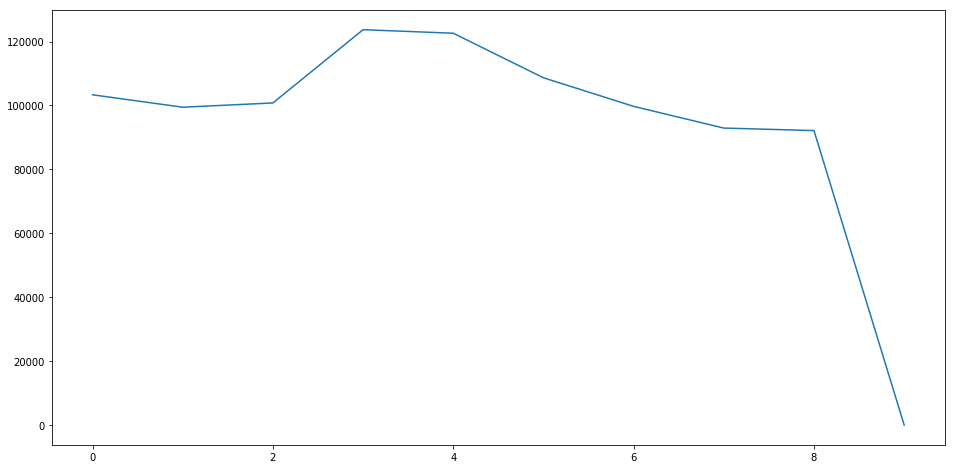

In [83]:
a=moveFocus(sid=1,step=-300)
pop=np.zeros(10)
pop[0]=focusMetric()
print(pop[0])
for ctt in range(1,9):
    moveFocus(sid=1,step=25)
    pop[ctt]=focusMetric()
    print(pop[ctt])
plt.plot(pop)


rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 -100"


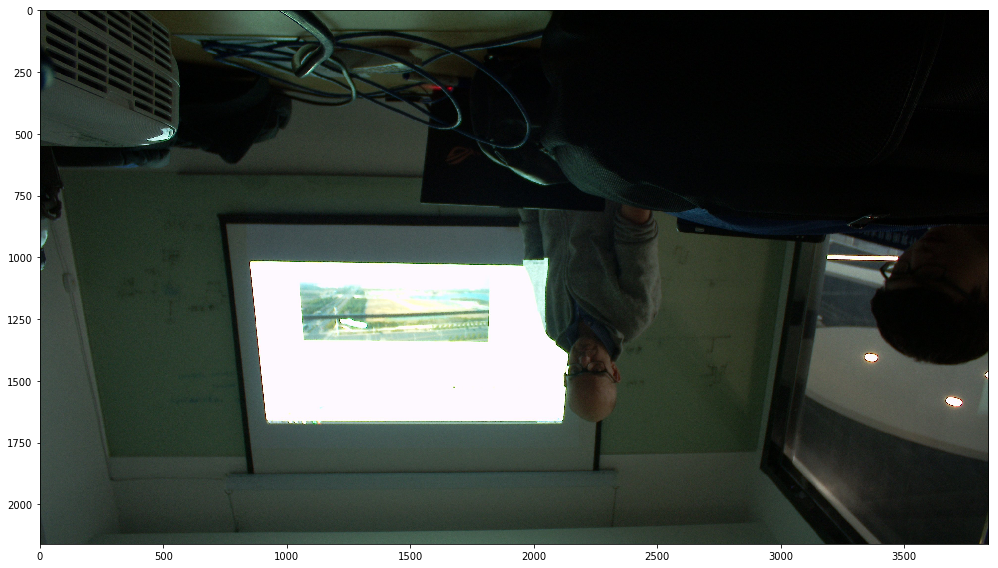

In [84]:
a=moveFocus(sid=1,step=-100)
pip=grabImage(sid=0, imres=8)
imio.imshow(pip)

rsh ubuntu@10.0.1.6 "python2 ~/bin/moveFocusMotor.py 1 -500"


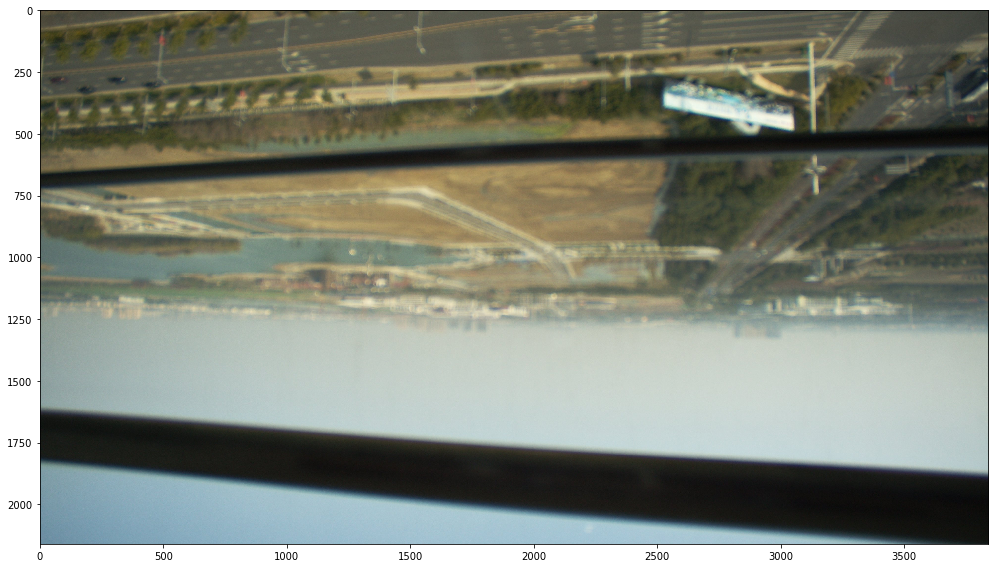

In [52]:
a=moveFocus(sid=1,step=-500)
pip=grabImage(sid=0, imres=8)
imio.imshow(pip)